# Fractional Occupations in Psi4
## Written by: Anthony Osborne
For use with the thermal inversion project 

### Import and Set up Section
Memory is likely set way too large but that is safest.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(15.50e9))
psi4.set_num_threads(10)
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to  14.435 GiB by Python driver.
  Threads set to 10 by Python driver.


#### Options to turn off parts of code to save time when running entire notebook. Set to True for on and False for off

In [2]:
Do_Ou_Carter = False # Option used to determine if The Ou-Carter method is used for n2v Only set up for water at the moment
Options_testing = False # Option used to determine if the example fractional occupation is calculated. Leave off unless something major is broken. Might even be better to just remove this cell
index_test = False # Option used to determine if Orbitals and their energies are calculated seperately and printed. Leave off unless something major is broken
Fermi_Testing = False # Option used to determine if the test for the Fermi_to_Frac function is tested. Leave off unless something major is broken. Again another cell that could possibly be removed
Water_testing = True # Option used to determine if fractional occupations for water are to be tested. Turn off to save some time if testing other molecules

#### Molecular Set up
Can and will define mulitple molecules to be tested.

In [3]:
#Molecules should all work
F = psi4.geometry(
    """
    0 2
    F 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="F")
H2O = psi4.geometry(
    """
    O
    H 1 0.96
    H 1 0.96 2 104.5 #what is this here 
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Water")
CH4 = psi4.geometry(
    """ 
    C       -0.70207        1.95893        0.00000
    H        0.39013        1.95893       -0.00000
    H       -1.06613        1.99095        1.02924
    H       -1.06613        1.05158       -0.48689
    H       -1.06614        2.83427       -0.54235
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Methane")
CCCC = psi4.geometry(
    """ 
    C        0.60024       -1.20973        0.11111
    C       -0.36574        2.49231        0.54931
    C       -1.34777       -0.08504        3.23689
    C        2.34127        0.92942        2.79869
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Graphite")
Ne = psi4.geometry(
    """
    0 1
    Ne 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Ne")
NH3 =psi4.geometry(
    """
    0 1
    N       -0.58187        0.48713       -0.03712
    H        0.43546        0.50133        0.01948
    H       -0.89347        1.40498        0.27725
    H       -0.89347       -0.17373        0.67317
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Ammonia")


### Functions Used in the calculations

#### Fractional Occupation Options Function

In [4]:
def FracOccOpts(Use=bool, testing=bool, Working=bool, frac_occ=None, frac_val=None):
    options = {
        'basis': 'sto-6g',
        'scf_type': 'direct',
        'reference': 'uhf',
        'df_scf_guess': False,
        'e_convergence': 8,
        "opdm": True,
        'tpdm': True,
        'DFT_SPHERICAL_POINTS': 74,
        'DFT_RADIAL_POINTS': 56,
        'MAXITER' : 1500,
    }

    if Use and testing:
        options.update({
            'frac_start': 1,
            'frac_occ' : [ +3, +4, +5, -3, -4, -5 ],
            'frac_val' : [1.0, 1.0, 1.0, 6.666666666666666e-01, 6.666666666666666e-01, 6.666666666666666e-01],
        })
    if Use and Working:
        options.update({
            'frac_start': 1,
            'frac_occ': frac_occ,
            'frac_val': frac_val,
        })

    psi4.set_options(options)


#### Fractional Occupation function test

In [5]:
dummy_occs = [ +3, +4, +5, +6, -3, -4, -5, -6 ]
dummy_vals = [1.0, 1.0, 1.0, 0.5, 6.666666666666666e-01, 6.666666666666666e-01, 6.666666666666666e-01, 0.5]
if Options_testing == True:
    FracOccOpts(True, False, True, dummy_occs, dummy_vals) # type: ignore #, dummy_occs, dummy_vals) # In order to change from True to False you must restart the kernel
    testEnergy, frac_occd_wfn = psi4.energy('svwn/cc-pvtz', molecule=F, return_wfn=True,) # type: ignore
    #print(testEnergy)
    if testEnergy == -98.91325301570028: # This number came from a Psi4 as an executable run without fractional occupations all other things held constant
        print("No Fractional Occupations were used. Energy is:", testEnergy) 
    else: # This number came from a Psi4 as an executable run with fractional occupations all other things held constant
        print("Fractional Occupation Occured. Energy is:", testEnergy)

##### Inverting with Fractional occupations test For atoms
See [Fluorine and Neon test For Imac](/Users/aosborne3/Desktop/Grad_Research/Code/Examples_Tutorials/Tutorials/PSI4/Fractional_Occupations/Fluorine_N2V_TEST.ipynb)\
See [Fluorine and Neon test For MacBook](/Users/tonyosborne/Desktop/Grad_Research/Code/Examples_Tutorials/Tutorials/PSI4/Fractional_Occupations/Fluorine_N2V_TEST.ipynb)



#### Thermodynamic Properties function

In [25]:
#Thermoproperties function
def thermo_prop(wfn, base_energy, temp, press, Spin_mult, molecular_mass, rotational_constants):
    data_output = psi4.driver.qcdb.vib.thermo(wfn.frequency_analysis, E0=base_energy, T=temp, P=press, sigma=1, molecular_mass=molecular_mass, multiplicity=Spin_mult, rot_const=rotational_constants)
    # Sets first element of data_output as the dictionary and takes care of it
    if isinstance(data_output, tuple) and len(data_output) > 0:
        data_output = data_output[0]  # Assuming the first element is the dictionary
    return data_output

#### Chemical potential function

In [7]:
def Pressure_Printer(data_set):
    P = data_set['P'].data    
    print(P)

In [8]:
def chemical_potential(data_set, T, print="n"):
    R = psi4.constants.R * 2.294e+17
    G_tot = data_set['G_tot'].data  # Total Gibbs free energy in Eh
    P = data_set['P'].data          # Pressure P in Pa

    # Calculate chemical potential
    P0 = 100000  #  IUPAC STP pressure in Pa 
    mu = G_tot + R * T * np.log(P / P0)

    

    # Optionally, print mu
    if print == "y":
        print(f"G_tot: {G_tot}") # type: ignore
        print(f"Chemical potential (mu): {mu} ")  # type: ignore
        mu_kcal_per_mol = mu * psi4.constants.hartree2kcalmol
        print(f"Chemical potential (mu): {mu_kcal_per_mol} kcal/mol")  # type: ignore

    return mu


#### Fermi Weighting function
Form of the Fermi weighting is:
$f = (1 + e^{(\epsilon^{\tau}_i - \mu^{\tau})/\tau})^{-1}$

In [9]:
## Converting real temperature to electronic temperature
def convert_temp(temp):
    K_b = 3.166811563e-6
    tau = K_b * temp
    return tau

temp = 298.15
print("For a real temperature of", temp, "K the electronic temperature should be: ", convert_temp(temp))

For a real temperature of 298.15 K the electronic temperature should be:  0.00094418486750845


In [10]:
def fermi_weighting(energy, chemical_potential, temperature):
    elec_temp = convert_temp(temperature)
    exponent = (energy - chemical_potential)/elec_temp
    expoenential = np.exp(exponent)
    base = 1 + expoenential
    fermi = base**(-1)
    return fermi


#### Getting the Fractional occupation indices

In [11]:
def print_orbital_info(wavefunction):
    # Get orbital information from wavefunction
    orbital_info = wavefunction.epsilon_a().to_array()  # Orbital energies
    num_occ = wavefunction.nalpha()  # Number of occupied orbitals
    
    # Print out occupied orbital indices and energies
    print("Occupied Orbital Indices and Energies:")
    for i in range(num_occ):
        orbital_index = i + 1  # PSI4 uses 1-based indexing for orbitals
        orbital_energy = orbital_info[i]
        print(f"Orbital {orbital_index}: Energy = {orbital_energy}")


##### Indices testing

In [12]:
if index_test == True:
    FracOccOpts(False, False, False)  # type: ignore
    Molec, name = H2O, "Water"
    Index_test_frequency, index_test_wfn = psi4.frequency('scf', molecule = Molec, return_wfn = True)
    print_orbital_info(index_test_wfn)

#### Fermi Weights to Fractional Occupation Values

In [13]:
def calc_Fermi_weight(orbital_energies, mu, T):
    # Calculate Fermi weightings
    fermi_weights = []
    for energy in orbital_energies:
        f = fermi_weighting(energy, mu, T)
        fermi_weights.append(f)
    return fermi_weights

def fermi_to_frac_val(fermi_weights_list):
    frac_val_list = []
    for fermi_weights in fermi_weights_list:
        frac_val = []
        for f in fermi_weights:
            if isinstance(f, list):
                frac = []
                for value in f:
                    if value >= 1.0:
                        n = 1.0  # Full occupation (positive fraction)
                    elif value <= 0.0:
                        n = 0.0  # No occupation (zero fraction)
                    else:
                        n = value  # For weights between 0 and 1, use as-is (positive fraction)
                    frac.append(n)
                frac_val.append(frac)
            else:
                if f >= 1.0:
                    n = 1.0  # Full occupation (positive fraction)
                elif f <= 0.0:
                    n = 0.0  # No occupation (zero fraction)
                else:
                    n = f  # For weights between 0 and 1, use as-is (positive fraction)
                frac_val.append(n)
        frac_val_list.append(frac_val)
    return frac_val_list

##### Fermi2Frac testing

In [14]:
if Fermi_Testing == True:
    # Example Fermi weights lists (multiple arrays)
    fermi_weights_list = [
        [0.9, 0.8, 1.0],   # Fermi weights for state 1
        [0.7, 0.6, 0.5],   # Fermi weights for state 2
        [0.95, 0.85, 0.75] # Fermi weights for state 3
    ]

    # Convert Fermi weights to fractional occupations
    frac_occ_list = fermi_to_frac_val(fermi_weights_list)

    # Print fractional occupations
    for i, frac_occ in enumerate(frac_occ_list):
        print(f"Fractional Occupations for state {i+1}:")
        for j, n in enumerate(frac_occ):
            print(f"  Orbital {j+1}: {n}")


#### Printing Function so I don't have to keep copying large cells

In [15]:
def print_big_info(orbital_energies, fermi_weights, frac_val_list, print_orb_energies=bool):
    if print_orb_energies:
        print("Orbital energies for each KS State:")
        for i, energy in enumerate(orbital_energies):
            print(f"State {i+1}: {energy} Hartree")
    # Print Fermi weightings
    print("Fermi weightings for each KS state:")
    for i, f in enumerate(fermi_weights):
        print(f"State {i+1}: f = {f}")
    #Print out fractional occupations
    for i, frac_val in enumerate(frac_val_list):
        print(f"Fractional Occupation Values for state {i+1}:")
        for j, n in enumerate(frac_val):
            print(f"  Orbital {j+1}: {n}")

### Regular SCF (No Fractional Occupations) of Water

#### Calculating the energy for water

In [16]:
FracOccOpts(False, False, False)  # type: ignore
Molec, name = H2O, "Water"
Water_Energy, Water_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Water_frequency, Water_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Water_Energy)

The total energy of the specified Water molecule is: -74.64686072440504


#### Using the energy of water to calculate thermodynamic properties 
then using those properties to calculate the chemical potential and ultimately the Fermi weighting

In [33]:
rot_const = np.array([27.87700, 14.51200, 9.28500]) # From https://cccbdb.nist.gov/exp2x.asp?casno=7732185
T =  298.15
P = 101325
#water_thermo_data = thermo_prop(Water_wfn2, Water_frequency, T, P, 18, 1, rot_const)
data_output, lib = psi4.driver.qcdb.vib.thermo(Water_wfn2.frequency_analysis, E0=Water_frequency, T=T, P=P, sigma=1, molecular_mass=18, multiplicity=1, rot_const=rot_const)
print(lib)
#print(water_thermo_data)
#Pressure = Pressure_Printer(water_thermo_data) # type: ignore
#Water_mu = chemical_potential(water_thermo_data, T)
#print(f"The chemical potential of the system is: mu = {Water_mu}")
#print(Water_wfn.same_a_b_orbs())
#Water_orbital_energies_alpha = Water_wfn.epsilon_a().nph
#Water_Orbitals_alpha = Water_wfn.Ca()
#print(Water_wfn.nalpha())
#print(Water_wfn.nbeta())
#print(Water_orbital_energies_alpha)
#Water_Fermi_weights_alpha = calc_Fermi_weight(Water_orbital_energies_alpha, Water_mu, T)
#print(Water_Fermi_weights_alpha)
#frac_val_list_alpha = fermi_to_frac_val(Water_Fermi_weights_alpha) 
#print_big_info(Water_orbital_energies_alpha, Water_Fermi_weights_alpha, frac_val_list_alpha, False)  # type: ignore


  ==> Thermochemistry Components <==

  Entropy, S
    Electronic S                             0.000 [cal/(mol K)]        0.000 [J/(mol K)]       0.00000000 [mEh/K] (multiplicity = 1)
    Translational S                         34.607 [cal/(mol K)]      144.794 [J/(mol K)]       0.05514899 [mEh/K] (mol. weight = 18.0000 [u], P = 101325.00 [Pa])
    Rotational S                            11.839 [cal/(mol K)]       49.533 [J/(mol K)]       0.01886621 [mEh/K] (symmetry no. = 1)
    Vibrational S                            0.000 [cal/(mol K)]        0.000 [J/(mol K)]       0.00000000 [mEh/K]
  Total S                                   46.445 [cal/(mol K)]      194.327 [J/(mol K)]       0.07401520 [mEh/K]
  Correction S                               0.000 [cal/(mol K)]        0.000 [J/(mol K)]       0.00000000 [mEh/K]

  Constant volume heat capacity, Cv
    Electronic Cv                            0.000 [cal/(mol K)]        0.000 [J/(mol K)]       0.00000000 [mEh/K]
    Translational Cv

In [18]:
Water_orbital_energies_beta = Water_wfn.epsilon_b().nph
#print(Water_orbital_energies_beta)
Water_Fermi_weights_beta = calc_Fermi_weight(Water_orbital_energies_beta, Water_mu, T)
frac_val_list_beta = fermi_to_frac_val(Water_Fermi_weights_beta) 
print_big_info(Water_orbital_energies_beta, Water_Fermi_weights_beta, frac_val_list_beta, True)  # type: ignore

Orbital energies for each KS State:
State 1: [-18.56327173  -1.21534944  -0.70888333  -0.39420639  -0.33003178
   0.04431892   0.12055983   0.38860236   0.4345112    0.48254053
   0.59376704   0.6917343    0.70517838   0.70756885   0.84434705
   0.85718749   1.18805452   1.49703379   1.70485838   1.72983466
   1.76007676   1.82768931   1.83715156   2.32385411   2.88524194
   2.96019818   2.987498     3.15292775   3.21632988   3.27490601
   3.3727049    3.6440226    3.71580052   3.86017199   4.17492731
   4.27126815   4.30000658   4.57353994   4.68133257   4.83004754
   5.21218483   5.23546508   5.8556755    5.95424529   6.03080441
   6.13017149   6.5578306    6.58586579   6.6580767    7.88535916
   7.92033121   8.38505253   8.80062718   8.97304507   9.28582763
   9.86135539  11.90871525  21.23220229] Hartree
Fermi weightings for each KS state:
State 1: f = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

### Fractional Occupations for Water

#### Manually trying new factional occupations

In [19]:
#test_Occs = [+1, +2, -1, -2] 
#Test_values = [1, 1, 0.48111183, 0.46503572]
# Last working set: 1 - 6 
#test_Occs = [+1, +2, +3, +4, +5, +6, -1, -2, -3, -4, -5, -6] 
#Test_values = [1, 1, 1, 1, 1, 1, 0.48111183, 0.46503572, 0.4654729202742443, 0.4652103301619441, 0.46515678040514274, 0.46484442384199415]
# Currently testing set: 3-8 
# 8th is a virtual orbital I think 
test_Occs = [+3, +4, +5, +6, +7, +8, -3, -4, -5, -6, -7, -8] 
Test_values = [1, 1, 1, 1, 1, 1, 0.4654729202742443, 0.4652103301619441, 0.46515678040514274, 0.46484442384199415, 0.4647808121454412, 0.46455717961153353]
#Three_Occs = [+1, +2, +3, -1, -2, -3] 
#Three_values = [1, 1, 1, 0.48111183, 0.46503572, 0.46347614]
I_Fixed_it = True
if I_Fixed_it == False:
    raise Exception("There is an error in the way you are loading the new occupations and values")
if Water_testing == True:
    FracOccOpts(True, False, True, test_Occs, Test_values) # type: ignore # In order to change from True to False you must restart the kernel
    Water_Frac_Energy, Water_Frac_wfn = psi4.properties("svwn/cc-pvtz", molecule=H2O, return_wfn=True) # type: ignore
    #FracOccOpts(True, False, True, Three_Occs, Three_values) # In order to change from True to False you must restart the kernel
    #Three_Water_Frac_Energy, Three_Water_Frac_wfn = psi4.properties("svwn/cc-pvtz", molecule=H2O, return_wfn=True)
    #Water_test_frequency, Water_wfn2 = psi4.frequency('scf', molecule = Molec, return_wfn = True)
    #frequency, wfn2 = psi4.frequency('scf', molecule = F, return_wfn = True)
    if Water_Frac_Energy == Water_frequency:
        print("No Fractional Occupations were used. Energy is:", Water_Frac_Energy) 
    else:
        print("Fractional Occupation Occured occured. Energy is:", Water_Frac_Energy)
        print(f"Regular (non fractionally occupied) energy is; {Water_frequency}")

Fractional Occupation Occured occured. Energy is: -72.42397974849005
Regular (non fractionally occupied) energy is; -74.64686072440647


#### Inverting Using Direct method

In [20]:
Invert_Water = n2v.Inverter.from_wfn(Water_Frac_wfn)
# Build 1D grid
x = np.linspace(-3,5,801)
y = [0]
z = [0]
grid, shape = Invert_Water.eng.grid.generate_grid(x,y,z)

# Run the calculation with requested grid
vxc_inverted_Water = Invert_Water.invert('direct', grid=grid, correction=False)
vxc_inverted_corr_Water = Invert_Water.invert('direct', grid=grid, correction=True)
#Compare the performance of direct and reversed calculation of vxc. 
vxc0_Water = Invert_Water.eng.grid.vxc(Da=Water_Frac_wfn.Da().np, Db=Water_Frac_wfn.Db().np, grid=grid) # type: ignore
#Invert_Water.invert("mRKS", vxc_grid=grid, opt_max_iter=30, frac_old=0.8, init="scan", sing=(1e-7, 1e-4, 1e-7, 1e-4))

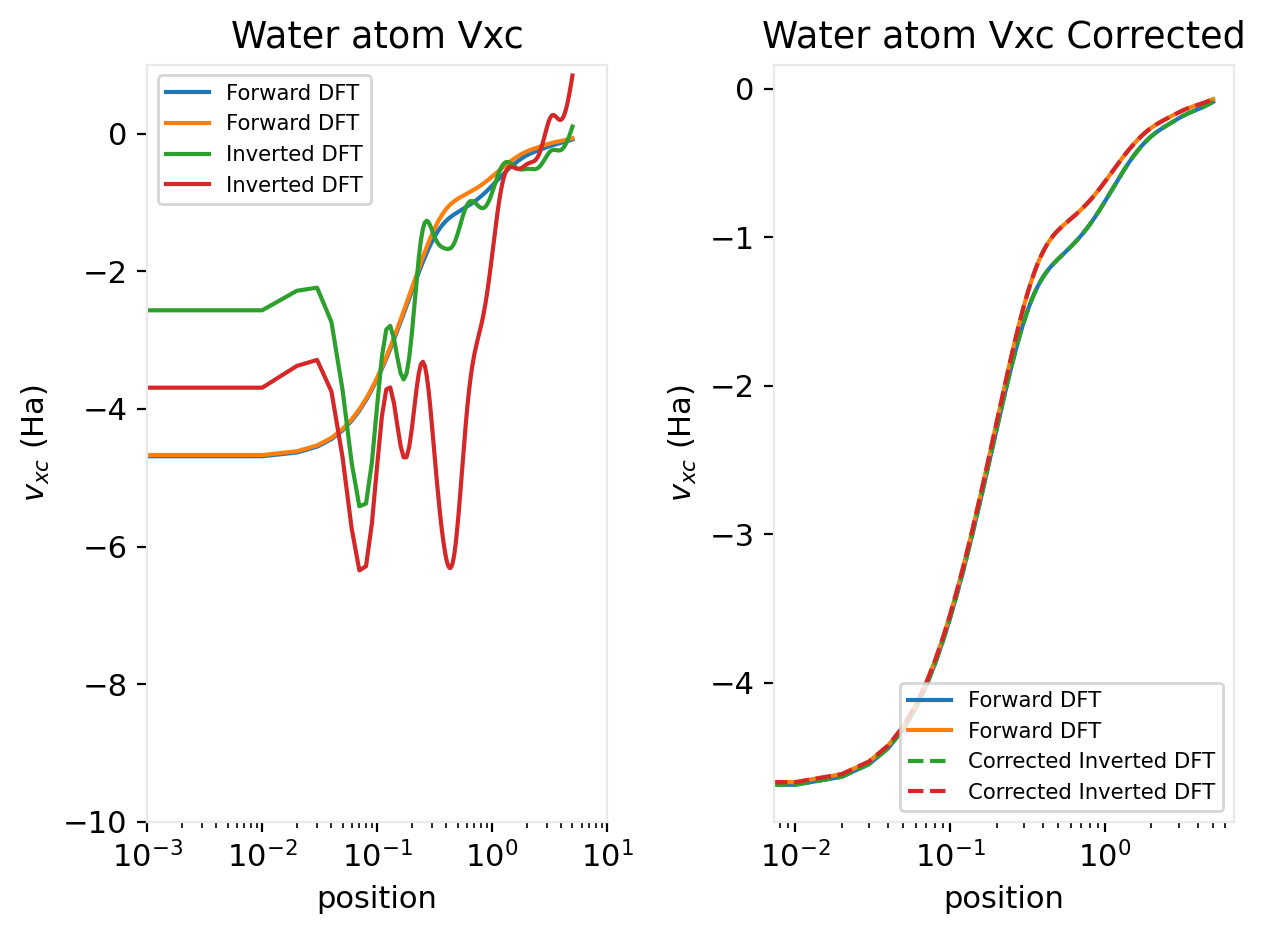

In [21]:
fig, ax = plt.subplots(1, 2, dpi=200)
#---------------> Data
ax[0].plot(x, vxc0_Water, label="Forward DFT")
ax[0].plot(x, vxc_inverted_Water, label="Inverted DFT")
ax[1].plot(x, vxc0_Water, label="Forward DFT")
ax[1].plot(x, vxc_inverted_corr_Water, '--',label="Corrected Inverted DFT")
#---------------> Formatting
#-------> Labels
ax[0].set_xlabel('position')
ax[0].set_ylabel('$v_{xc}$ (Ha)')
ax[0].legend(loc='best', fontsize='x-small')
ax[0].set_xlabel('position')
ax[1].set_xlabel('position')
ax[1].set_ylabel('$v_{xc}$ (Ha)')
ax[1].legend(loc='best', fontsize='x-small')
#-------> Titles
ax[0].title.set_text('Water atom Vxc')
ax[1].title.set_text('Water atom Vxc Corrected')
#-------> Sizing
ax[0].set_xlim(0.001,10)
ax[0].set_ylim(-10, 1)
#ax[1].set_xlim(0.001,10)
#ax[1].set_ylim(-10, 1)
#ax[0, 0].set_box_aspect(1)
#ax[0, 1].set_box_aspect(1)
#ax[1, 1].set_box_aspect(1)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.00
#fig.suptitle("Water Molecule Fractionally Occupied Direct Vxc")

#### Inverting using the Ou-Carter method

In [22]:
if Do_Ou_Carter == True:
    # Build the plotting grid for vxc:
    x_OC = np.linspace(-5,5,1501) + 1e-7
    y_OC = [0]
    z_OC = [0]
    grid_OC, shape_OC = Invert_Water.eng.grid.generate_grid(x_OC,y_OC,z_OC)
    v_OC = Invert_Water.invert("OC", vxc_grid=grid_OC, frac_old=0.9, init="SCAN") #opt_max_iter=29, frac_old=0.9, init="SCAN")
    ## Turn grid into psi4 blocks:
    #grid_info = Invert_Water.eng.grid.grid_to_blocks(grid)  # turing grid into psi4 block infomation
    #grid_info[-1].set_pointers(Water_wfn.Da())

    ## Get exact and effective external potential
    #vext = Invert_Water.eng.grid.esp(grid=grid_info)[0]
    #vext_eff = Invert_Water._get_optimized_external_potential(grid_info=grid_info,)[-1]
    #---------------> Plot
    fig, ax = plt.subplots(1, 1, dpi=200)
    #---------------> Data

    ax.axhline(y=0, ls='--', label='y=0')
    ax.plot(x_OC, v_OC[0].T, label="$v_{xc}$")  # type: ignore
    #---------------> Formatting
    #-------> Labels
    ax.set_xlabel('Position')
    ax.set_ylabel('$v_{ext}$ (Ha)')
    ax.legend()
    #-------> Titles
    ax.title.set_text('Water (Fractionally occupied) $V_{xc}$ Ou_Carter Method')
    #-------> Sizing
    #ax.set_xlim(-5,5)
    #ax.set_ylim(-30, 30)
    # Log limits
    ax.set_xlim(0.001,10)
    ax.set_xscale('log')
    fig.tight_layout()
    #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.00

Inverting with Other methods seems unnecessary and we can not invert a uhf with mRKS

### Testing Code on $NH_3$

In [23]:
FracOccOpts(False, False, False)  # type: ignore
Molec, name = NH3, "Ammonia"
Ammonia_Energy, Ammonia_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Ammonia_frequency, Ammonia_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Ammonia_Energy)
# 9.44430	9.44430	6.19600

 '9643.4786i']
The total energy of the specified Ammonia molecule is: -52.629193859638214


In [24]:
rot_const = np.array([9.44430, 9.44430, 6.19600]) # From https://cccbdb.nist.gov/exp2x.asp?casno=7664417&charge=0
T =  298.15
P = 101325
Ammonia_thermo_data = thermo_prop(Ammonia_wfn2, Ammonia_frequency, T, P, 17, rot_const)
Ammonia_mu = chemical_potential(Ammonia_thermo_data, T)
print(f"The chemical potential of the system is: mu = {Ammonia_mu}")
#print(Water_wfn.same_a_b_orbs())
Ammonia_orbital_energies_alpha = Ammonia_wfn.epsilon_a().nph
print_orb_energies = False
Ammonia_Fermi_weights_alpha = calc_Fermi_weight(Ammonia_orbital_energies_alpha, Ammonia_mu, T)
frac_val_list_alpha = fermi_to_frac_val(Ammonia_Fermi_weights_alpha) 
#print_big_info(Ammonia_orbital_energies_alpha, Ammonia_Fermi_weights_alpha, frac_val_list_alpha, False)  # type: ignore

TypeError: thermo_prop() missing 1 required positional argument: 'rotational_constants'

### Testing code on $CH_4$

In [ ]:
FracOccOpts(False, False, False) # type: ignore
raise Exception("Convergence issue Please reevaluate me")
Molec, name = CH4, "Methane"
Methane_energy, Methane_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Methane_frequency, Methane_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Methane_frequency)
rot_const = np.array([5.24120, 5.24120, 5.24120]) #From https://cccbdb.nist.gov/expgeom2.asp?casno=74828&charge=0
T =  298.15
P = 101325
Methane_thermo_data = thermo_prop(Methane_wfn2, Methane_frequency, T, P, 16, rot_const)
Methane_mu = chemical_potential(Methane_thermo_data, T)
print(f"The chemical potential of the system is: mu = {Methane_mu}")
#print("These are not correct you need to update the rotational constants. Also make sure they are correct for all molecules")
Methane_orbital_energies = Methane_wfn.epsilon_a().nph
Methane_Fermi_weights = calc_Fermi_weight(Methane_orbital_energies, Methane_mu, T)
frac_val_list = fermi_to_frac_val(Methane_Fermi_weights)
#print_big_info(Methane_orbital_energies, Methane_Fermi_weights, frac_val_list, False) #type: ignore

### Test for Graphite/Graphene cannot get scf to converge 

In [ ]:
#FracOccOpts(False, False)
#Molec, name = CCCC, "Graphite/Graphene"
#Energy_Graph, wfn_Graph = psi4.energy('scf', molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True))
#frequency_Graph, wfn2_Graph = psi4.frequency('scf', molecule = Molec, return_wfn = True)
#print("The total energy of the specified", name, "molecule is:", frequency_Graph)
